# Maximum Likelihood - Code

***

First a simple **probability mass function** is introduced to provide an implementation of the foundational **Information Theory** material given in the related Theory book. A **Binomial Distribution** is then introduced and the method of **Maximum Likelihood** is used to determine this distribution. For this distribution the **Fisher Information** is computed as well.

**Note**: *This notebook is an implementation of the theory given in [this notebook](Maximum%20Likelihood%20-%20Theory.ipynb). The sections closely mirror each other.*

## Shannon Entropy

Define a pmf $p(x)$ as below and find the uncertainty

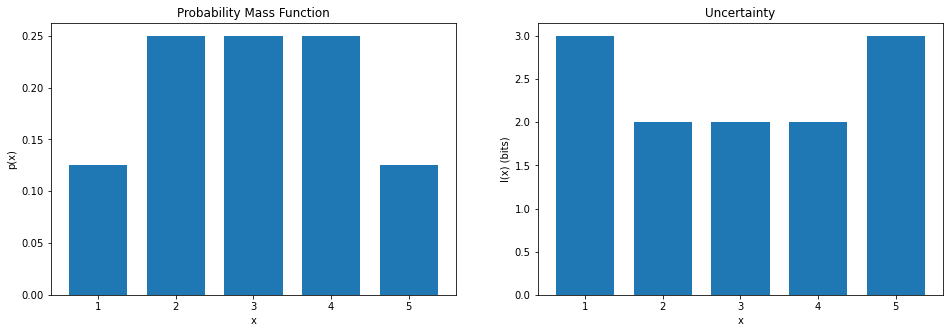

In [1]:
import numpy as np 
import matplotlib.pyplot as plt

x = np.arange(1, 6)
pmf_p = np.array([0.125, 0.25, 0.25, 0.25, 0.125])

pmf_hist_bins = np.arange(0.5, 6)

uncertainty_p = np.log2(1/pmf_p)

fig, axs = plt.subplots(1,2, figsize=(16,5))
axs[0].hist(x, pmf_hist_bins, weights=pmf_p, rwidth=0.75);
axs[0].set_title("Probability Mass Function")
axs[0].set_xlabel("x")
axs[0].set_ylabel("p(x)");

axs[1].hist(x, pmf_hist_bins, weights=uncertainty_p, rwidth=0.75);
axs[1].set_title("Uncertainty")
axs[1].set_xlabel("x")
axs[1].set_ylabel("I(x) (bits)");

Find the Entropy and the code that achieves entropy

In [2]:
entropy_p = np.dot(uncertainty_p, pmf_p)
print("The Entropy is: ", entropy_p)

The Entropy is:  2.25


## Entropy as a Measure of Information

Since the pmf is made up of powers of $\frac{1}{2}$ there exists a code that can achieve this entropy, i.e. 2.25 bits. 

We find that the following Huffman code achieves the entropy:

$$
\begin{split}
1 &\rightarrow 000\\
2 &\rightarrow 01\\
3 &\rightarrow 10\\
4 &\rightarrow 11\\
5 &\rightarrow 001\\
\end{split}
$$

## Cross-Entropy

Consider another pmf $q(x)$ as given below. We find the Entropy for $q(x)$, the Cross Entropy with respect to $p(x)$ and the Relative Entropy $D_{KL}(p\|q)$

In [3]:
x = np.arange(1, 6)
pmf_q = np.array([0.2, 0.2, 0.2, 0.2, 0.2])

pmf_hist_bins = np.arange(0.5, 6)
uncertainty_q = np.log2(1/pmf_q)

entropy_q = np.dot(uncertainty_q, pmf_q)
cross_entropy_q = np.dot(uncertainty_q, pmf_p)
relative_entropy_pq = cross_entropy_q-entropy_p

print("The entropy for q(x) is: ", entropy_q)
print("The cross-entropy for q(x) w.r.t p(x) is: ", cross_entropy_q)
print("The relative entropy is: ", relative_entropy_pq)

The entropy for q(x) is:  2.321928094887362
The cross-entropy for q(x) w.r.t p(x) is:  2.321928094887362
The relative entropy is:  0.07192809488736218


## Maximum Likelihood

We now switch to the task of identifying a specific model from within a class of models. Let the random variable $X$ have the following probability mass function:

$$p_X(x) = {10 \choose x}0.1^x(0.9)^{10-x}$$

We find the entropy of this distribution as:

$$
\begin{split}
H_X &= \sum_{x\in X}p_X(x)\log_2{\frac{1}{p_X(x)}}\\
&= \sum_{x=0}^{10}p_X(x)\log_2{\frac{1}{p_X(x)}}
\end{split}
$$

We evaluate this in the code below:

In [25]:
from scipy.special import comb

x = np.arange(0,11)
c = comb(10, x)
p_success = np.power(0.1, x)
p_fail = np.power(0.9, 10-x)
p_X = c*p_success*p_fail
uncertainty = 1/p_X

uncertainty_neg = np.log2(uncertainty)
entropy = np.dot(p_X, uncertainty_neg)
print("The Entropy is:", entropy)

The Entropy is: 1.8436306064892138


This means that with an appropriate coding, the average codeword length will be 1.8 bits

We now introduce the task of finding this specific probability distribution from within a class of distributions, i.e. the binomial distribution given some realisations. For ease of computation, and to facilitate the use of the Maximum Likelihood, we will consider the subset of all possible binomial distributions with the following pdf:

$$
p(x) = {n\choose x}p^x(1-p)^{n-x}
$$

We generate the samples we will use to find the true distribution below:

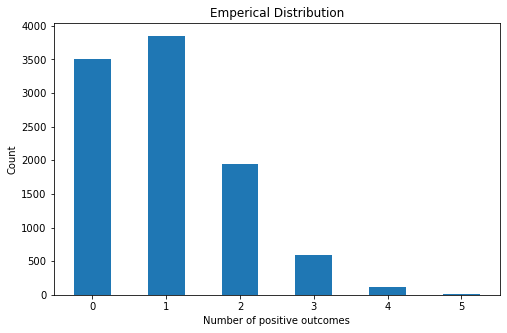

In [145]:
np.random.seed(159)

sample_count = 1000
x = np.random.binomial(10, 0.1, sample_count)

fig,ax = plt.subplots(1,1,figsize=(8,5))
ax.set_title("Emperical Distribution")
ax.set_xlabel("Number of positive outcomes")
ax.set_ylabel("Count")

bins = np.arange(-0.5, np.max(x))
ax.hist(x, bins = bins, rwidth=0.5);

We will now forget that we know the true distribution and given these samples above, will begin the hunt for the true distribution. 

**Note**: *This is slightly disingenuous, we will also use the knowledge that the true distribution comes from the class of binomial distributions as mentioned in the theory notebook*. 

We will evaluate the log likelihood function over a range of $\theta = \begin{bmatrix}n& p\end{bmatrix}$ values and see which value of $\theta$ maximises this function i.e. $$\sum_{i=1}^k \log{p_x(x_i|\theta)}$$ where $k$ is the number of samples we have and $x_i$ is an indexed sample. While the class of model restricts the value $p \in [0, 1]$ and $n \in \mathbb{Z}, 
n > 0$ 

In [142]:
def log_likelihood_binomial(p, n, x):
    #n choose x
    n_choose_x = comb(n[:, np.newaxis], x) #matrix shape(n*x)
    n_choose_x = np.repeat(n_choose_x[np.newaxis, :, :], p.shape[-1], 0) #matrix shape(p*n*x)

    #p^x
    p_exp_x = np.power(p[:, np.newaxis], x) #matrix shape(p*x)
    p_exp_x = np.repeat(p_exp_x[:, np.newaxis, :], n.shape[-1],1) #matrix shape(p*n*x)

    #(1-p)^(n-x)
    n_minus_x = n[:, np.newaxis]-x #matrix shape(n*x)
    non_negative_index = n_minus_x>=0
    n_minus_x_pos = np.select([non_negative_index, ~non_negative_index], [n_minus_x, 0])
    fail_prob = 1-p
    fail_prob_exp = np.power(fail_prob[:, np.newaxis, np.newaxis], n_minus_x_pos) #matrix shape(p*n*x)

    #p(x)
    p_x = np.multiply(np.multiply(n_choose_x, p_exp_x), fail_prob_exp)

    log_likelihood = np.sum(p_x, 2)
    return log_likelihood

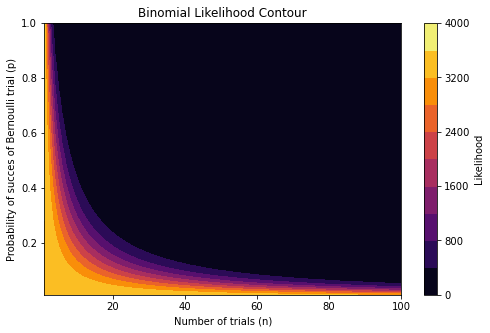

In [146]:
n = np.arange(1, 101)
p = np.linspace(0.01, 1, 100)

log_likelihood = log_likelihood_binomial(p, n, x)

fig, ax = plt.subplots(1,1,figsize=(8,5))
ax.set_title("Binomial Likelihood Contour")
ax.set_ylabel("Probability of succes of Bernoulli trial (p)")
ax.set_xlabel("Number of trials (n)")
CS = ax.contourf(n, p, log_likelihood, levels=10, cmap=plt.cm.inferno)
c_bar = fig.colorbar(CS)
c_bar.ax.set_ylabel("Likelihood");

We have clearly been exploring too wide a range. The likely values for $\theta$ are from $x \in [0, 20]$ and $p \in [0, 0.2]$

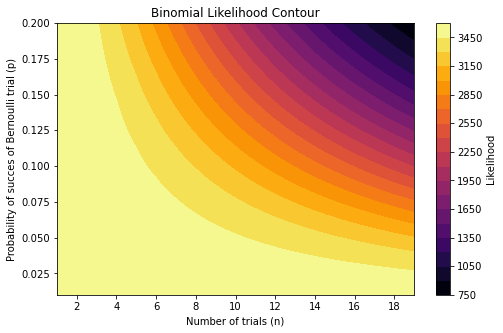

In [154]:
n = np.arange(1, 20)
p = np.linspace(0.01, 0.2, 100)

log_likelihood = log_likelihood_binomial(p, n, x)

fig, ax = plt.subplots(1,1,figsize=(8,5))
ax.set_title("Binomial Likelihood Contour")
ax.set_ylabel("Probability of succes of Bernoulli trial (p)")
ax.set_xlabel("Number of trials (n)")
CS = ax.contourf(n, p, log_likelihood, levels=20, cmap=plt.cm.inferno)
c_bar = fig.colorbar(CS)
c_bar.ax.set_ylabel("Likelihood");

We appear now to have reached an impasse. We make one last attempt to increase the resolution of the above log-likelihood function.

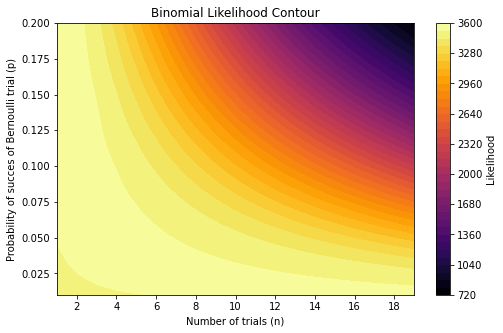

In [156]:
fig, ax = plt.subplots(1,1,figsize=(8,5))
ax.set_title("Binomial Likelihood Contour")
ax.set_ylabel("Probability of succes of Bernoulli trial (p)")
ax.set_xlabel("Number of trials (n)")
CS = ax.contourf(n, p, log_likelihood, levels=40, cmap=plt.cm.inferno)
c_bar = fig.colorbar(CS)
c_bar.ax.set_ylabel("Likelihood");

We thus find that there is a lower limit that the maximum likelihood model sugests for the values of n and p. While we have not arrived at our true distribution, we have significantly honed in on the value of $\theta$.

## Fisher Information

We first evaluate the score function

$$
\begin{split}
s(\theta) = \begin{bmatrix}\frac{\partial \log{\big({n\choose x}p^x(1-p)^{n-x}}\big)}{\partial n}\\\frac{\partial \log{\big({n\choose x}p^x(1-p)^{n-x}}\big)}{\partial p}\end{bmatrix}
\end{split}
$$

Taking the derivative with respect to $n$ does not make much sense here as we know that it can only assume integer values. Thus, we will consider the derivative solely with respect to the value of $p$ which will yield the score function for a subset of models from the class of binomial distributions with a fixed $n$ i.e.

$$
\begin{split}
s(p) &= \frac{\partial \log{\big({n\choose x}p^x(1-p)^{n-x}}\big)}{\partial p}\\
&= \frac{x - pn}{p(1-p)}
\end{split}
$$

And calculating the Fisher Information we get:

$$
\begin{split}
\mathcal{I} & = \mathbb{E}\Bigg[\bigg(\frac{x - pn}{p(1-p)}\bigg)^2\Bigg]\\
&= \mathbb{E}\Bigg[\frac{x^2 + p^2n^2 - 2npx}{p^2(1-p)^2}\Bigg]\\
&= \frac{n^2p^2 + np(1-p) + p^2n^2 - 2np(np)}{p^2(1-p)^2}\\
&= \frac{n}{p(1-p)}
\end{split}
$$

where the third equality comes from:

$$
\begin{split}
\mathbb{E}[X] &= np\\
\mathbb{E}[X^2] &= n^2p^2 + np(1-p)
\end{split}
$$

Thus for the set of models we are considering, the Fisher information becomes:

$$
\mathcal{I}(p) = \frac{10}{p(1-p)}
$$

## Cramer-Rao Inequality

We further find the minimum variance that an unbiased estimator $\hat\Theta$ must have as: $$\text{Var}_\hat\Theta \geq \frac{p(1-p)}{10}$$